In [3]:
!pip install umap-learn
!pip install --upgrade umap-learn

**Imports and global settings**

In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

import umap

from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.mixture import GaussianMixture
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN
from sklearn.cluster import OPTICS


import random
import time

std_figure_size = (8,5)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=14, titlepad=10)

fixed_random_state = random.seed(42)
n_parallel_jobs = -1

%config IPCompleter.use_jedi=False

## Vital Signs Unveiled: Key Indicators for Health and Disease Monitoring:

The motivation behind this research stems from the pressing need to improve the prediction and management of cardiovascular disease (CVD), a leading cause of mortality worldwide. Despite advancements in medical science, there remains a significant challenge in accurately predicting and detecting CVD in its early stages. This study seeks to address this challenge by leveraging machine learning (ML) and deep learning (DL) models to analyze physiological signs associated with CVD, including respiratory rate, blood pressure, body temperature, heart rate, and oxygen saturation. By comparing the performance of various ML and DL models with a previous study conducted by Ashfaq et al., we aim to identify the most effective prediction model.

https://www.kaggle.com/datasets/chidozieuzoegwu/cvd-vital-signs

**Reading in the dataset**

In [5]:
import pandas as pd

url = 'https://drive.google.com/file/d/1jaYd8w-8szosbE_fycRY65nUnTrQOuVg/view?usp=drive_link'

# Get the ID from the URL
file_id = url.split('/')[-2]

# Download the file from Google Drive
!wget --no-check-certificate 'https://docs.google.com/uc?export=download&id='{file_id} -O cvd_vital_sign.csv

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv('cvd_vital_sign.csv')
df.head()

--2024-06-28 00:34:58--  https://docs.google.com/uc?export=download&id=1jaYd8w-8szosbE_fycRY65nUnTrQOuVg
Resolving docs.google.com (docs.google.com)... 64.233.180.138, 64.233.180.113, 64.233.180.101, ...
Connecting to docs.google.com (docs.google.com)|64.233.180.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1jaYd8w-8szosbE_fycRY65nUnTrQOuVg&export=download [following]
--2024-06-28 00:34:58--  https://drive.usercontent.google.com/download?id=1jaYd8w-8szosbE_fycRY65nUnTrQOuVg&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.163.132, 2607:f8b0:4004:c1b::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.163.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1018352 (994K) [application/octet-stream]
Saving to: ‘cvd_vital_sign.csv’

cvd_vital_sign.csv  100%[===================>] 994.48K  --.-KB/

subject_id  icustay_id  heart_rate  blood_pressure  oxygen_saturation  \
0       94297    200697.0        93.0            94.0               98.0   
1       94229    219381.0        97.0            96.0               98.0   
2       94195    276193.0        82.0            96.0               97.0   
3       94256    241577.0        98.0           196.0               96.0   
4       93996    236789.0        98.0            92.0               99.0   

   respiratory_rate  temperature  Label  
0              39.0         36.0      1  
1              16.0         36.5      0  
2              25.0         36.3      1  
3              16.0         36.5      1  
4              28.0         37.2      1

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23468 entries, 0 to 23467
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         23468 non-null  int64  
 1   icustay_id         23468 non-null  float64
 2   heart_rate         23468 non-null  float64
 3   blood_pressure     23468 non-null  float64
 4   oxygen_saturation  23468 non-null  float64
 5   respiratory_rate   23468 non-null  float64
 6   temperature        23468 non-null  float64
 7   Label              23468 non-null  int64  
dtypes: float64(6), int64(2)
memory usage: 1.4 MB


In [7]:
def remove_random_rows(df, percentage):
    """
    Remove a percentage of rows randomly from the DataFrame.

    Parameters:
    df (pd.DataFrame): The original DataFrame.
    percentage (float): The percentage of rows to remove (between 0 and 100).

    Returns:
    pd.DataFrame: A new DataFrame with the specified percentage of rows removed.
    """
    # Calculate the fraction of rows to keep
    frac_to_keep = 1 - (percentage / 100.0)

    # Sample the DataFrame to keep the desired fraction of rows
    df_sampled = df.sample(frac=frac_to_keep, random_state=42)  # Use random_state for reproducibility

    return df_sampled

df = remove_random_rows(df, 95)

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 15841 to 6425
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         1173 non-null   int64  
 1   icustay_id         1173 non-null   float64
 2   heart_rate         1173 non-null   float64
 3   blood_pressure     1173 non-null   float64
 4   oxygen_saturation  1173 non-null   float64
 5   respiratory_rate   1173 non-null   float64
 6   temperature        1173 non-null   float64
 7   Label              1173 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 82.5 KB


**Any duplicate rows?**

In [8]:
n_dup = len(df) - len(df.drop_duplicates())

print(f"Number of duplicate rows: {n_dup}")

Number of duplicate rows: 0


**Any missing values?**

In [9]:
df.isnull().sum()

subject_id           0
icustay_id           0
heart_rate           0
blood_pressure       0
oxygen_saturation    0
respiratory_rate     0
temperature          0
Label                0
dtype: int64

**Checking data types**

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1173 entries, 15841 to 6425
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subject_id         1173 non-null   int64  
 1   icustay_id         1173 non-null   float64
 2   heart_rate         1173 non-null   float64
 3   blood_pressure     1173 non-null   float64
 4   oxygen_saturation  1173 non-null   float64
 5   respiratory_rate   1173 non-null   float64
 6   temperature        1173 non-null   float64
 7   Label              1173 non-null   int64  
dtypes: float64(6), int64(2)
memory usage: 82.5 KB


**Cleaning up column names (mainly for handling purposes)**

In [11]:
cols_cleaned = []

for col in df.columns:
    cols_cleaned.append(col.strip().lower())

df.columns = cols_cleaned

# sanity check
df.head()

subject_id  icustay_id  heart_rate  blood_pressure  oxygen_saturation  \
15841       69518    266873.0        97.0           120.0               97.0   
19143       82175    224314.0        91.0            93.0               99.0   
20359       77576    211902.0        90.0            85.0               97.0   
21114       76165    239678.0        66.0            93.0               97.0   
16935       47989    230854.0        94.0            97.0               98.0   

       respiratory_rate  temperature  label  
15841              16.0         36.5      0  
19143              27.0         38.0      1  
20359              26.0         37.3      1  
21114              23.0         36.2      1  
16935              16.0         37.5      0

**Quick overview over the individual distributions**

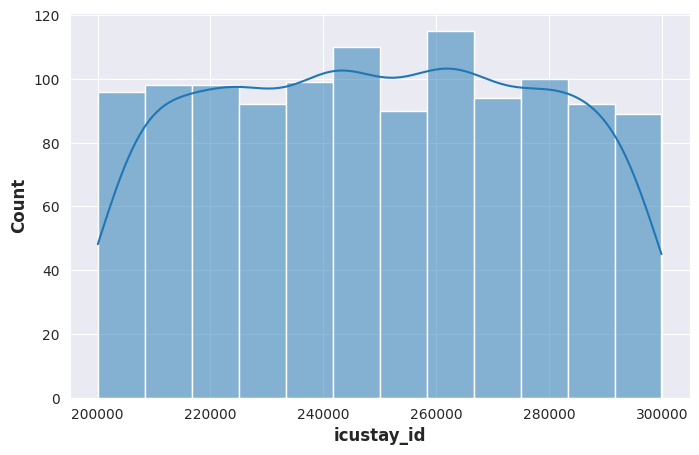

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x789b82e87010> (for post_execute):


KeyboardInterrupt: 

In [12]:
for col in df.columns:
    fig, axs = plt.subplots(figsize=std_figure_size)
    sns.histplot(data=df, x=col, kde=True, ax=axs)
    plt.show()

# Clustering

In [12]:
algos = ["K-means", "Mean shift", "Gaussian mixtures", "Affinity propagation", "DBSCAN", "OPTICS"]

# saving training times for each algo
training_times = []

## Scaling and Standardizing

In [13]:
X = StandardScaler().fit_transform(df)

In [14]:
X = PowerTransformer(standardize=False).fit_transform(X)

In [15]:
X = pd.DataFrame(X, columns=df.columns)

# sanity check
X.head()

subject_id  icustay_id  heart_rate  blood_pressure  oxygen_saturation  \
0    0.307163    0.603176  -19.003626        0.600651          -0.023139   
1    0.919382   -0.894285  -19.118104       -0.651536           0.049996   
2    0.688393   -1.329776  -19.137251       -1.272020          -0.023139   
3    0.619404   -0.354584  -19.602541       -0.651536          -0.023139   
4   -0.545521   -0.664647  -19.060779       -0.386677           0.015338   

   respiratory_rate  temperature     label  
0         -0.428048    -0.213135 -0.441969  
1          0.036291     0.029800  1.141161  
2          0.002565    -0.079457  1.141161  
3         -0.108476    -0.265619  1.141161  
4         -0.428048    -0.047495 -0.441969

## Dimensionality reduction via UMAP

Prior to clustering, the number of features is reduced from 7 to 2. The main reason behind this is to be able to **directly "see" if the identified clusters make sense**. In addition to this, (i) similarity metrics tend to work better in lower dimensions (distance measures degenerate for large numbers of input features), and (ii) this dimensionality reduction also mitigates the relatively poor "obervations to features ratio" for this dataset.

In [16]:
reducer = umap.UMAP(n_components=2, n_neighbors=25, n_jobs=n_parallel_jobs, random_state=fixed_random_state)
embedding = reducer.fit_transform(X)

X = pd.DataFrame(embedding, columns=["comp_1", "comp_2"])

In [17]:
plt.figure(figsize=std_figure_size)
sns.scatterplot(data= X, x="comp_1", y="comp_2")
plt.show()

## Definition of plotting and convergence check function

In [18]:
# function to visualize identified clusters

def visualize_clusters(*, df, labels_all, hyperparam_name, hyperparam_val, noise_exist):
    """Visualisation of identified clusters. Only a single hyperparameter is considered.

    Arguments
    =========
    df: pandas.DataFrame
        Dataframe of input features.
    labels_all: list | numpy.array
        Identified cluster IDs.
    hyperparam_name: str | None
        Name of hyperparameter.
    hyperparam_val: float | int | None
        Value of hyperparameter.
    noise_exist: bool
        True if algo models noise, False otherwise.
        Assumes encoding of noise as cluster ID = -1.

    Returns
    =======
    None
    Prints a figure.

    """

    # Checking of input parameters omitted for this notebook

    labels = sorted(pd.Series(labels_all).unique())

    if noise_exist:

        outlier_perc = int(round(( (len(df) - sum(np.where(labels_all == -1, False, True))) / len(df) ) * 100, 0))

        plt.figure(figsize=std_figure_size)
        for label in labels:
            if label == -1:
                marker_style = "*"
            else:
                marker_style = "o"
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label), marker=marker_style)
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}; 'Noise': {outlier_perc}%")
        else:
            plt.title(f"Defaults for all hyperparameters; 'Noise': {outlier_perc}%")
        plt.legend(title="cluster ID")
        plt.show()

    else:

        plt.figure(figsize=std_figure_size)
        for label in labels:
            sns.scatterplot(data=df.loc[labels_all == label, :], x="comp_1", y="comp_2", label=str(label))
        if hyperparam_name or hyperparam_val:
            plt.title(f"{hyperparam_name}: {hyperparam_val}")
        else:
            plt.title(f"Defaults for all hyperparameters")
        plt.legend(title="cluster ID")
        plt.show()


def convergence_check(model):
    """Checking if fitted model converged within the max. number of iterations."""
    if model.n_iter_ < model.max_iter:
        print(f"Algorithm converged successfully!\nn_iter: {model.n_iter_}, max_iter: {model.max_iter}\n")
    else:
        print(f"WARNING: Algorithm did not converge within {model.max_iter} iterations!\n")

## Algo 1: K-means

K-means is the most well-known and "basic" clustering algorithm.
Its most important hyperparamter is ***n_clusters***, which is the number of clusters for the algo to look for.

In [19]:
# hyperparameter to tune

kmeans_hparam = "n_clusters"

### Identifying the "optimal" number of clusters

In the context of clustering via K-means, the sum of squared distances of points to their respective centroid is known as "**inertia**". Finding an appropriate number of clusters here means finding the point of diminishing returns when increasing the number of centroids. This is done visually via identifying a potential kink in the inertia vs. number of clusters plot.

In [20]:
inertias_1 = []
range_clusters_1 = np.arange(2, 10, dtype=int)

for n in range_clusters_1:
    kmeans_1 = KMeans(n_clusters=n, random_state=fixed_random_state).fit(X)
    inertias_1.append(kmeans_1.inertia_)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

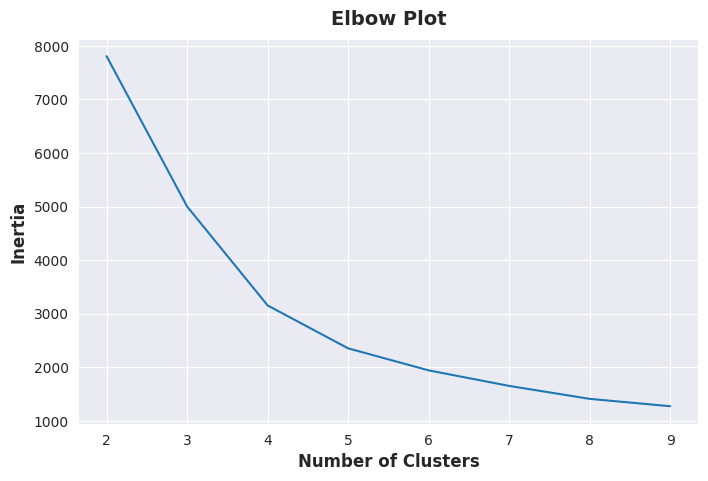

In [21]:
fig, axs = plt.subplots(figsize=std_figure_size)
sns.lineplot(x=range_clusters_1, y=inertias_1)
plt.title('Elbow Plot')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

==> Salient "kink" at 3 clusters. This is thus the number of clusters to go for. As discussed above, this is along the lines of what is to be expected by just looking at the data. [3, 5] clusters

### Run with optimised *n_clusters*

3 clusters

In [22]:
%%time

clusters = 4
start_time = time.time()

kmeans = KMeans(n_clusters=clusters, random_state=fixed_random_state)

labels_1 = kmeans.fit_predict(X)

convergence_check(kmeans)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 10, max_iter: 300

CPU times: user 54.5 ms, sys: 924 µs, total: 55.4 ms
Wall time: 36 ms


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [23]:
visualize_clusters(df=X, labels_all=labels_1, hyperparam_name=kmeans_hparam, hyperparam_val=clusters, noise_exist=False)


## Algo 2: Mean shift

Similar to K-means, Mean shift is a centroid-based algorithm. In contrast to K-means, however, there is **no requirement to specify the number of clusters upfront**. Its main hyperparameter is ***bandwidth***, which represents the extent of the "local search regions". If this parameter is not specified, however, sklearn does provide an estimation for it. Additionally, Mean shift also comes with the option to not necessarily associate all data points with a cluster via setting *cluster_all* to *False*. This aspect of the alogrithm is also explored in the following.

In [24]:
# hyperparamter to tune

meanshift_hparam = "bandwidth"

### Vanilla run (defaults for all hyperparameters)

In [25]:
%%time

start_time = time.time()

meanshift = MeanShift(n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_times.append(time.time() - start_time)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Algorithm converged successfully!
n_iter: 3, max_iter: 300

CPU times: user 480 ms, sys: 136 ms, total: 616 ms
Wall time: 4.24 s


In [26]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

### Allowing for 'noise'

This is enabled by setting *cluster_all=False*.

In [27]:
%%time

start_time = time.time()

meanshift = MeanShift(cluster_all=False, n_jobs=n_parallel_jobs)

labels_2 = meanshift.fit_predict(X)

convergence_check(meanshift)

training_time_meanshift_noise = time.time() - start_time

Algorithm converged successfully!
n_iter: 3, max_iter: 300

CPU times: user 338 ms, sys: 25.2 ms, total: 363 ms
Wall time: 1.37 s


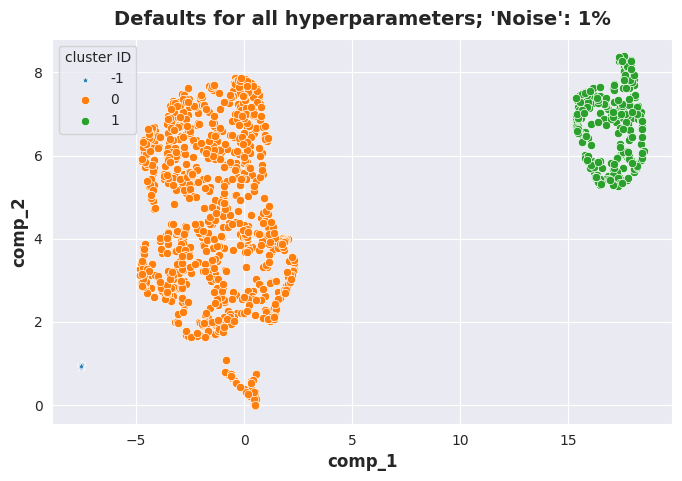

In [28]:
visualize_clusters(df=X, labels_all=labels_2, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 7%.

## Algo 3: Gaussian Mixture

The Gaussian mixture model is, as the name suggests, a distribution-based algorithm. Its main hyperparamter is ***n_components***, which corresponds to the number of clusters to form. As a shortcut here, the number of clusters as identified in the K-means section is adopted.

In [29]:
# hyperparamter to tune

gmm_hparam = "n_components"

In [30]:
%%time

start_time = time.time()

gmm = GaussianMixture(n_components=3, random_state=fixed_random_state)

labels_3 = gmm.fit_predict(X)

convergence_check(gmm)

training_times.append(time.time() - start_time)

Algorithm converged successfully!
n_iter: 26, max_iter: 100

CPU times: user 68.7 ms, sys: 34.7 ms, total: 103 ms
Wall time: 63.3 ms


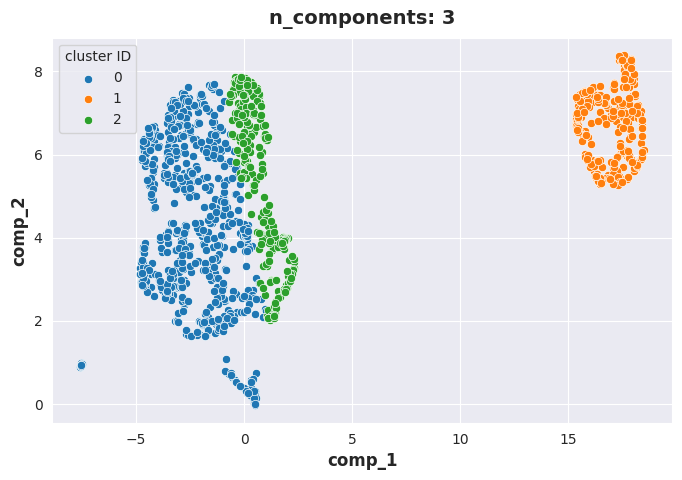

In [31]:
visualize_clusters(df=X, labels_all=labels_3, hyperparam_name=gmm_hparam, hyperparam_val=3, noise_exist=False)

## Algo 4: Affinity propagation

Affinity propagation does not require specifying the number of clusters upfront. Its main hyperparameter is ***damping***, which is a value in the range of 0.5 (incl.) to 1.0 (excl.).

In [32]:
# hyperparamter to tune

affprop_hparam = "damping"

### Vanilla run (defaults for all hyperparameters)

In [33]:
%%time

affprop = AffinityPropagation(random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)


CPU times: user 4.43 s, sys: 150 ms, total: 4.58 s
Wall time: 4.47 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


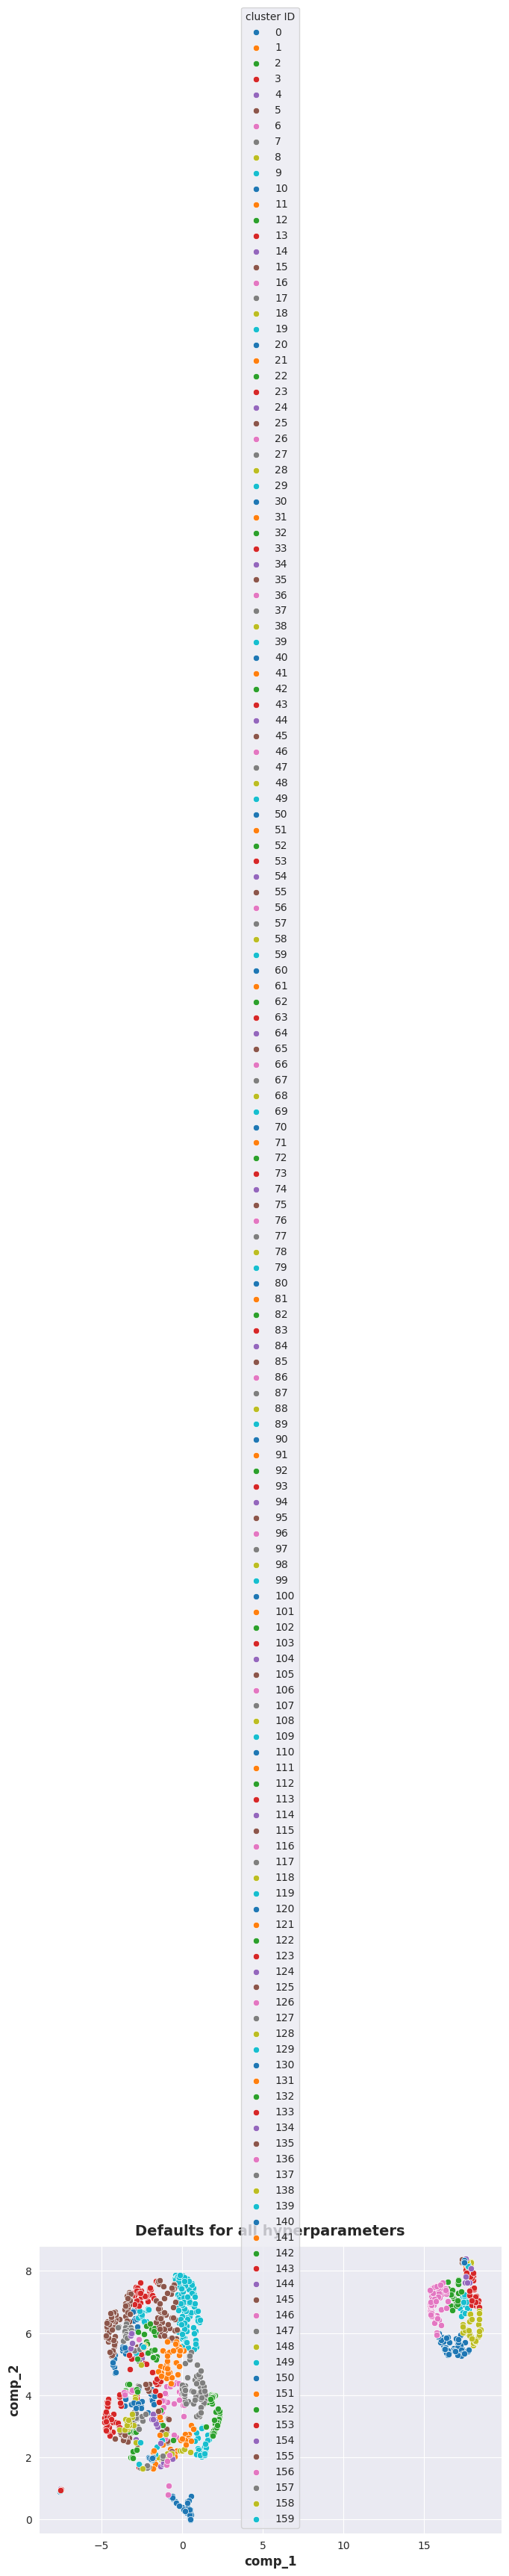

In [34]:
visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=None, hyperparam_val=None, noise_exist=False)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


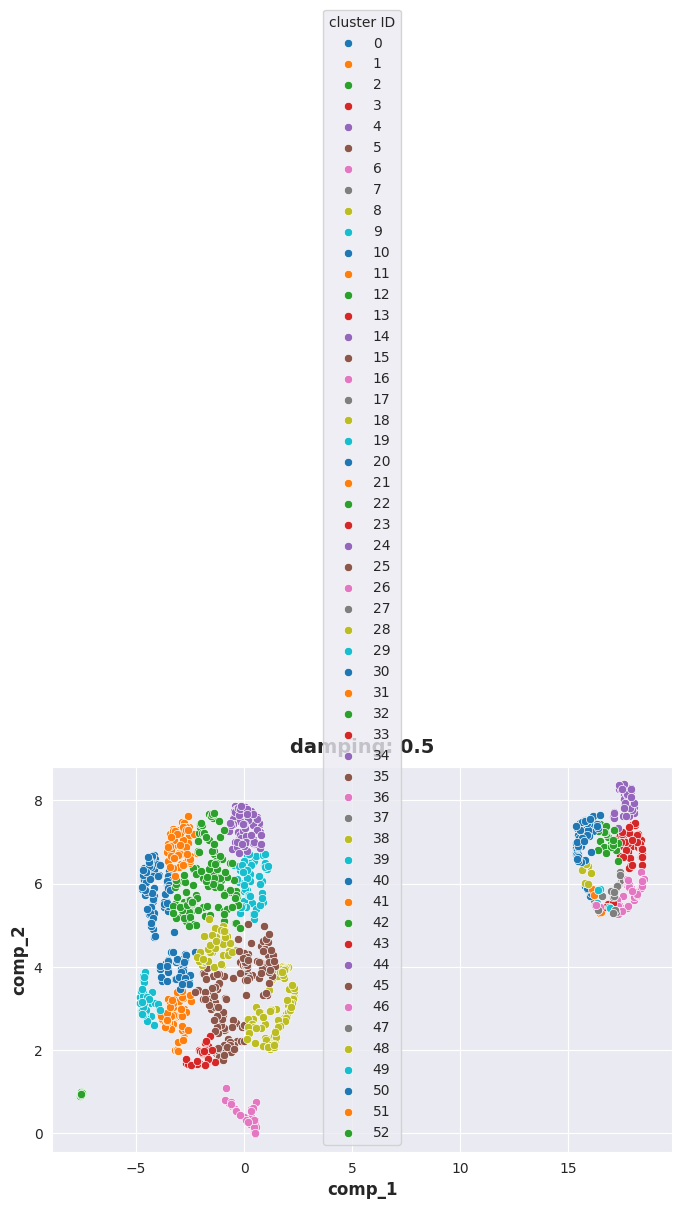

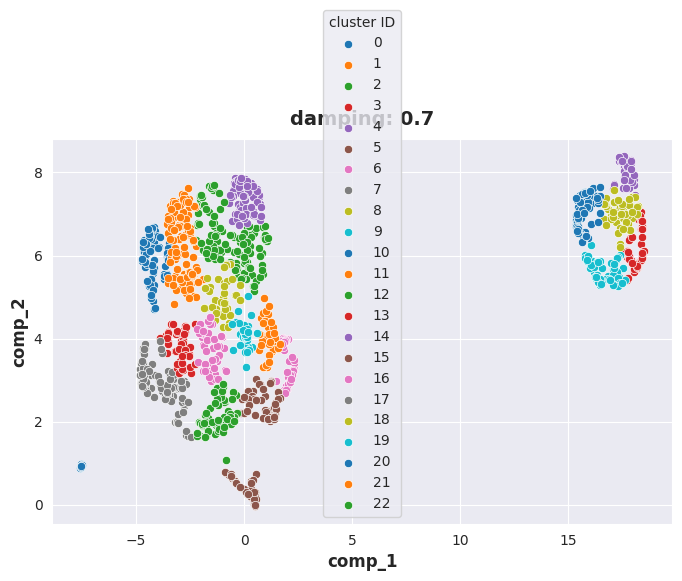

Algorithm converged successfully!
n_iter: 67, max_iter: 500



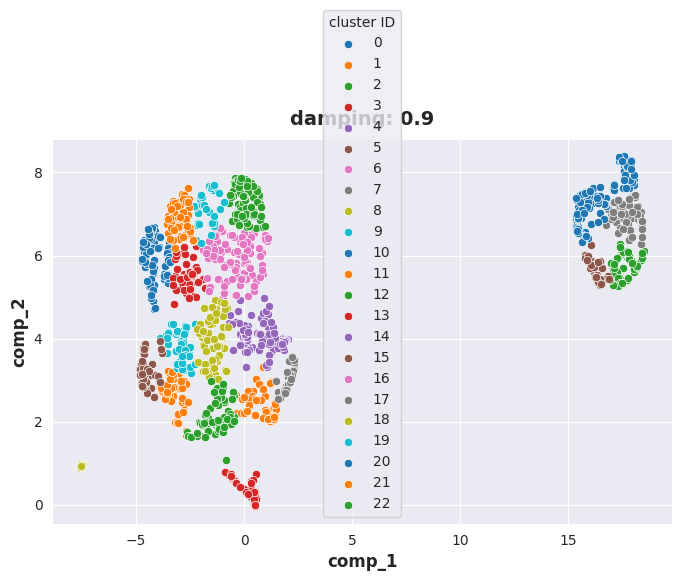

Algorithm converged successfully!
n_iter: 62, max_iter: 500



Algorithm converged successfully!
n_iter: 109, max_iter: 500



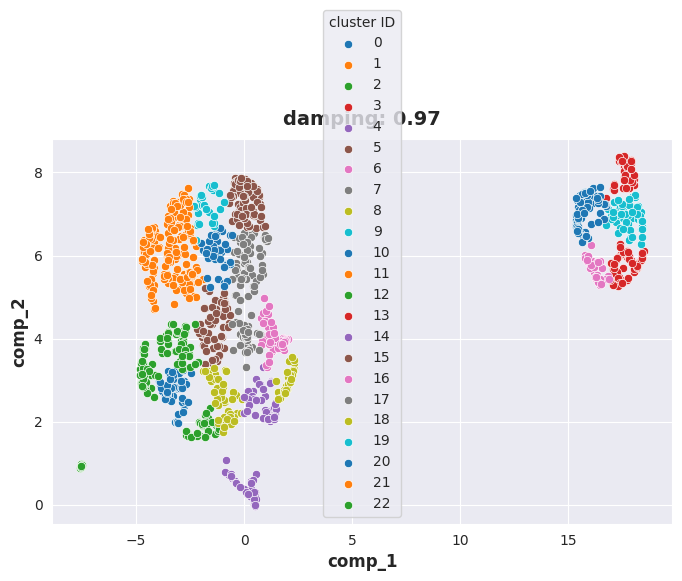

Algorithm converged successfully!
n_iter: 154, max_iter: 500



Algorithm converged successfully!
n_iter: 280, max_iter: 500

CPU times: user 37.8 s, sys: 1.34 s, total: 39.1 s
Wall time: 38.6 s


In [35]:
%%time

damps = [0.5, 0.7, 0.9, 0.95, 0.97, 0.99]

for d in damps:
    affprop = AffinityPropagation(damping=d, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=d, noise_exist=False)
    convergence_check(affprop)

### Tuning runs for "preference"

In order to still get to the "expected solution" of finding 3 clusters, another hyperparamter, ***preference*** is investigated. As stated in the beginning though, the self-imposed contraint here is to only tune a single hyperparameter, leaving all others at their default values, i.e. not looking for any interactions between them.

In [36]:
# hyperparamter to tune

affprop_hparam = "preference"

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


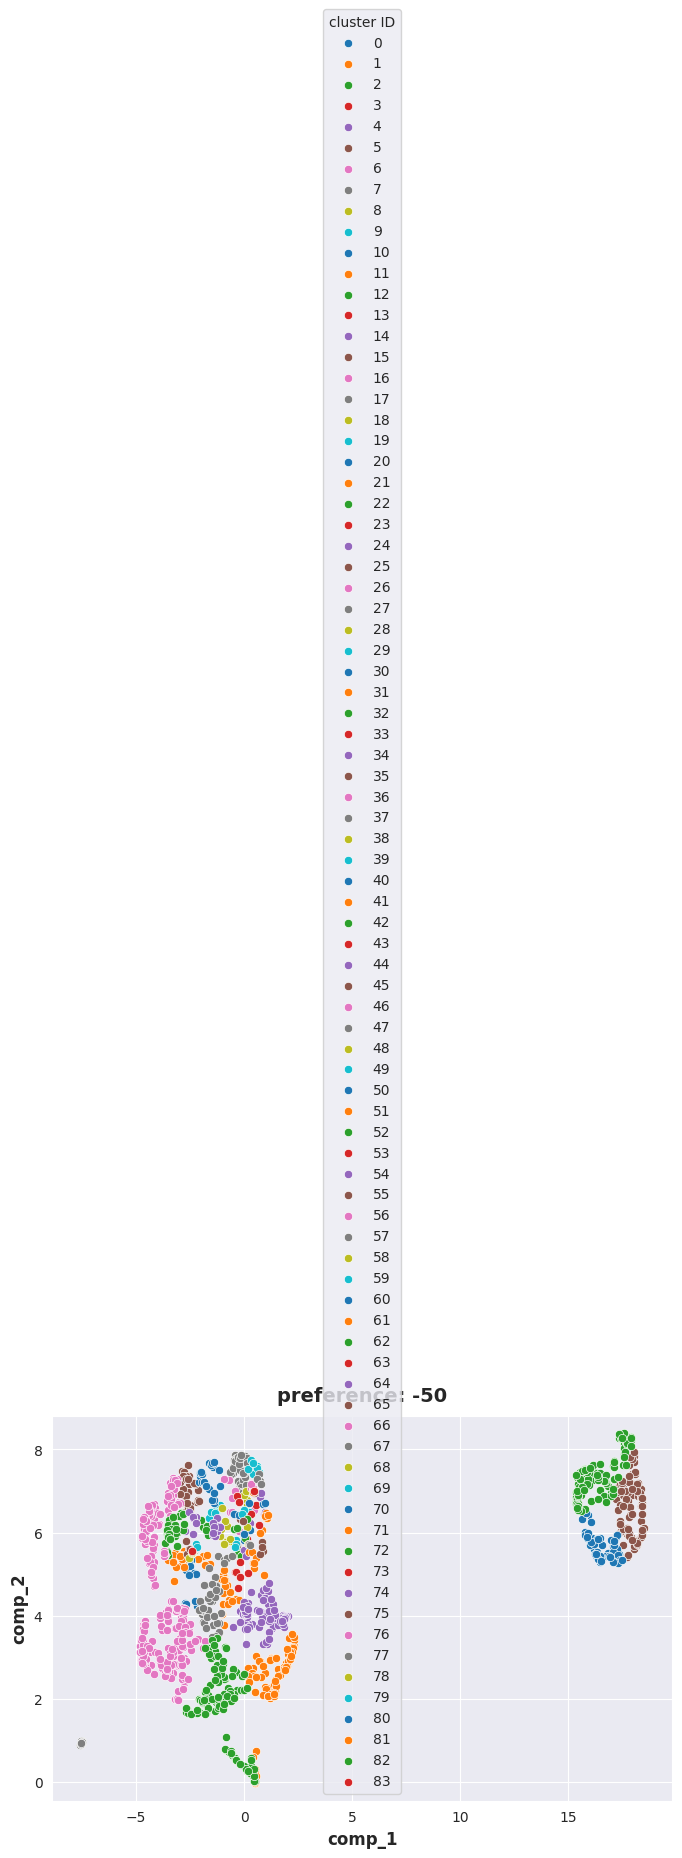

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


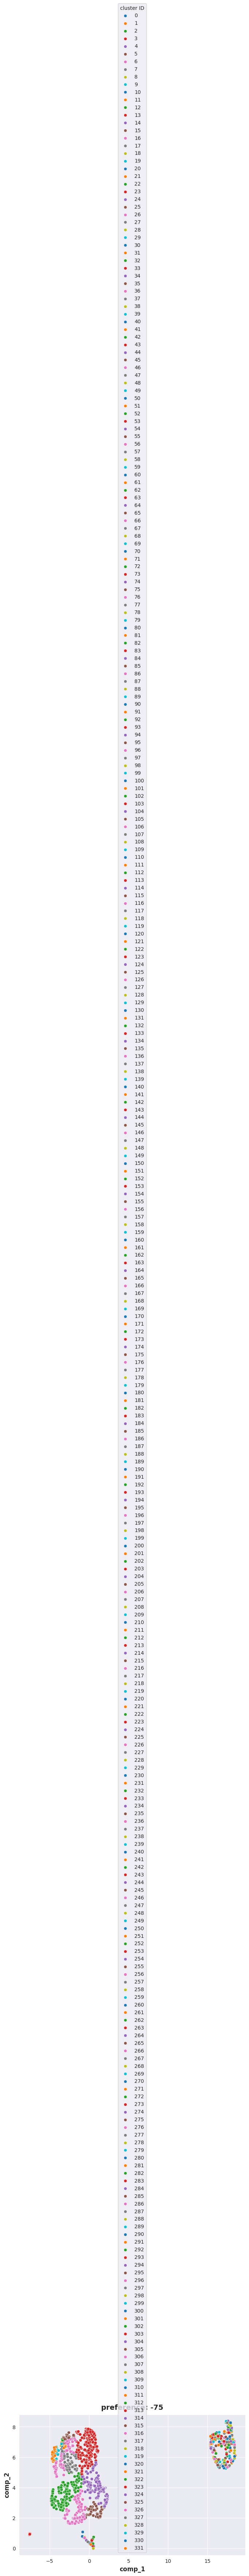

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


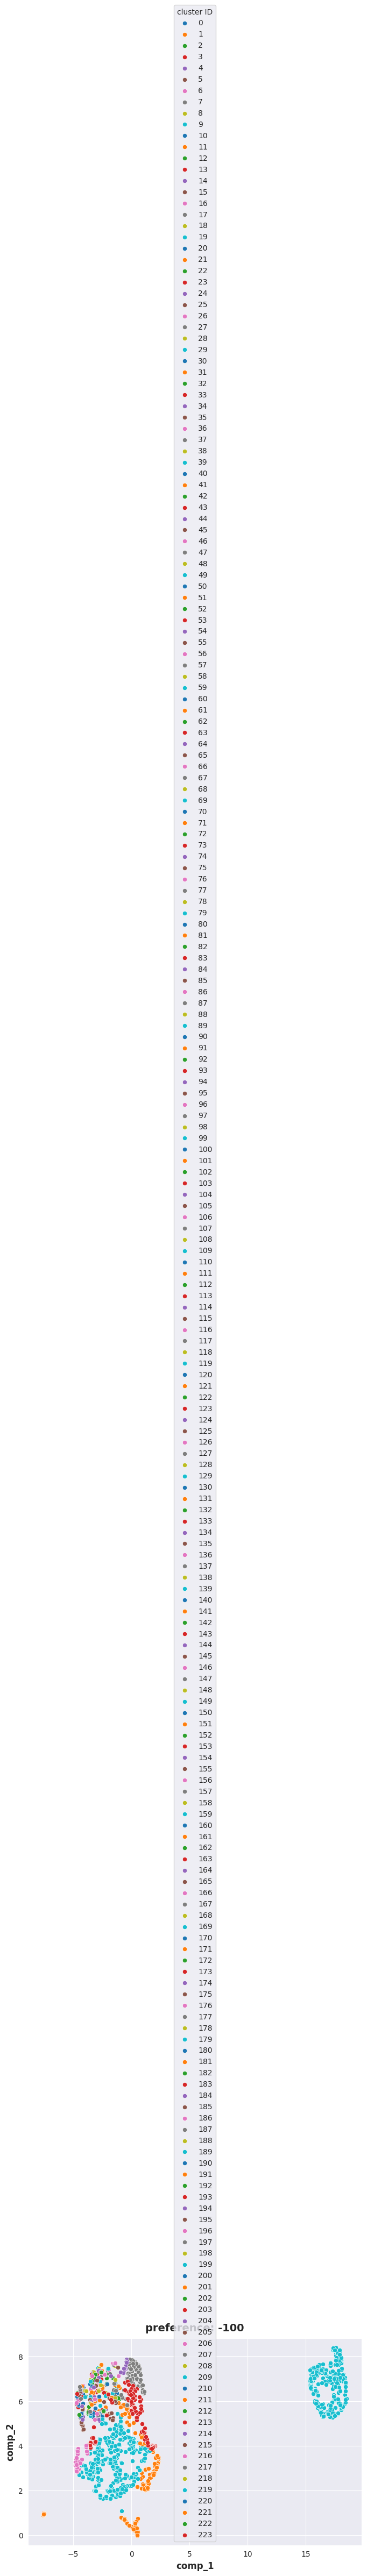


CPU times: user 3min 16s, sys: 2.72 s, total: 3min 19s
Wall time: 3min 19s


In [37]:
### Too much time calculating

%%time

prefs = [-10, -25, -50, -75, -100]

for p in prefs:
    affprop = AffinityPropagation(preference=p, max_iter=500, random_state=fixed_random_state)
    labels_4 = affprop.fit_predict(X)
    visualize_clusters(df=X, labels_all=labels_4, hyperparam_name=affprop_hparam, hyperparam_val=p, noise_exist=False)
    convergence_check(affprop)

### Re-run with optimised *preference*

In [38]:
%%time

start_time = time.time()

affprop = AffinityPropagation(preference=-75, max_iter=500, random_state=fixed_random_state)

labels_4 = affprop.fit_predict(X)

convergence_check(affprop)

training_times.append(time.time() - start_time)


CPU times: user 10.9 s, sys: 99 ms, total: 11 s
Wall time: 11 s


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_affinity_propagation.py:143: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


## Algo 5: DBSCAN

DBSCAN is a density-based algorithm. It assumes that clusters are of a **roughly similar density**. Its main hyperparameter is ***eps***, which is the maximum distance between two samples for one to be considered as in the neighborhood of the other. Its default value is 0.5. This algorithm comes with a second important hyperparamter, which is ***min_samples***. It represents the number of samples in a neighborhood for a point to be considered as a core point. *Min_samples* is not tuned in the context of this exercise though.

In contrast to algorithms 1 to 4, DBSCAN is **not iterative but deterministic** in nature. Thus no convergence check is required here.

A core feature of DBSCAN is that it also attempts to identify "**noise**", i.e. data points not associated with any cluster. Those data points are represented in the following plots as blue stars with cluster ID -1.

In [39]:
# hyperparamter to tune

dbscan_hparam = "eps"

### Vanilla run (defaults for all hyperparameters)

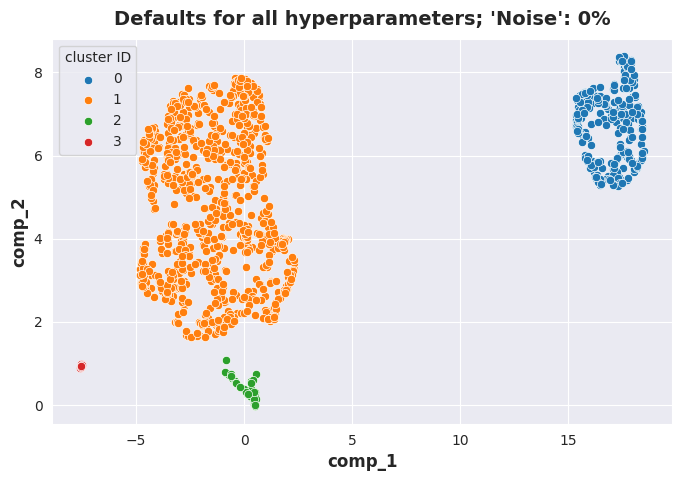

CPU times: user 485 ms, sys: 107 ms, total: 592 ms
Wall time: 486 ms


In [40]:
%%time

dbscan = DBSCAN(n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

Noise 1%, meaning?

### Tuning runs for *eps*

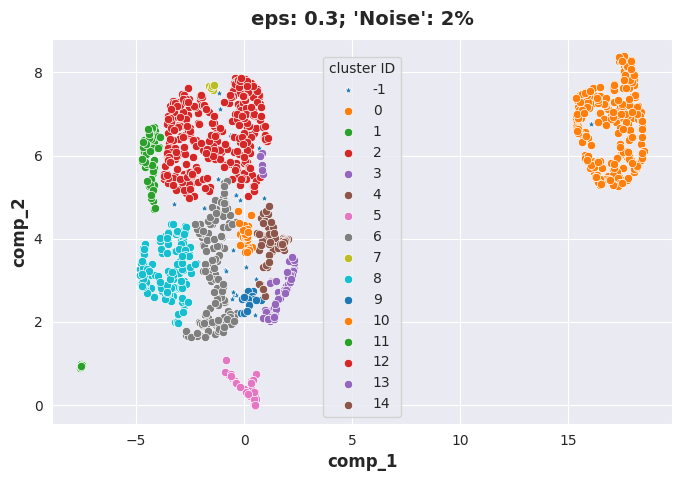

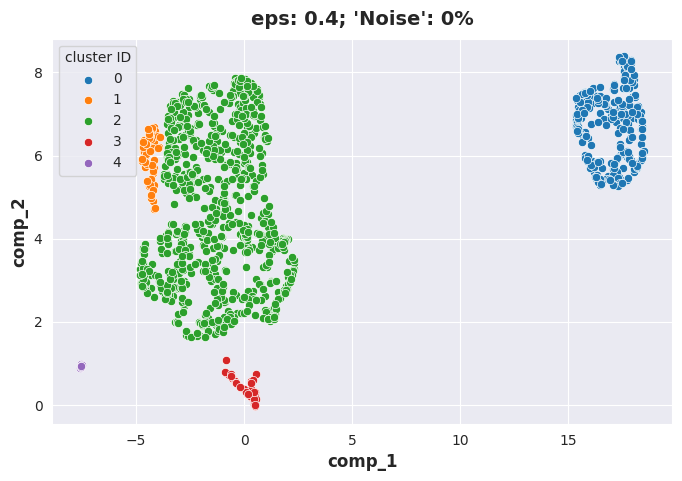

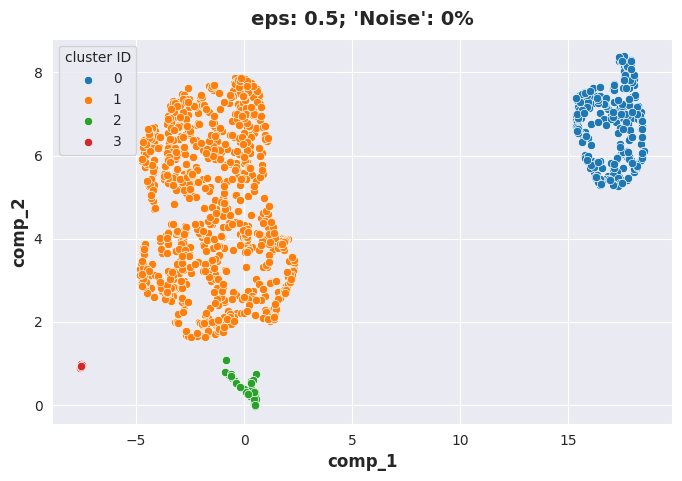

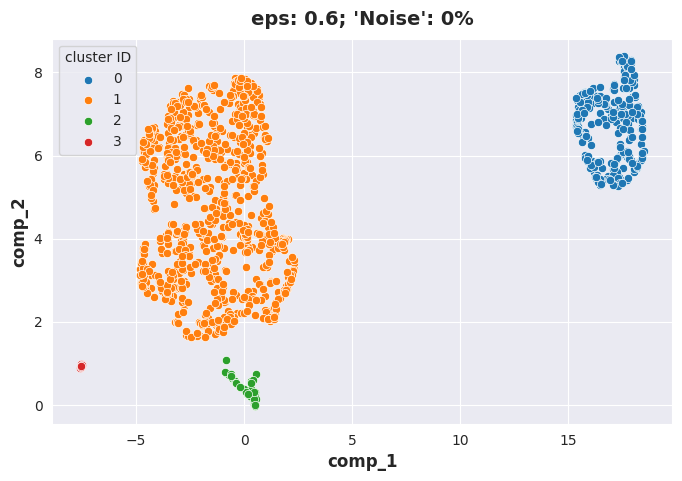

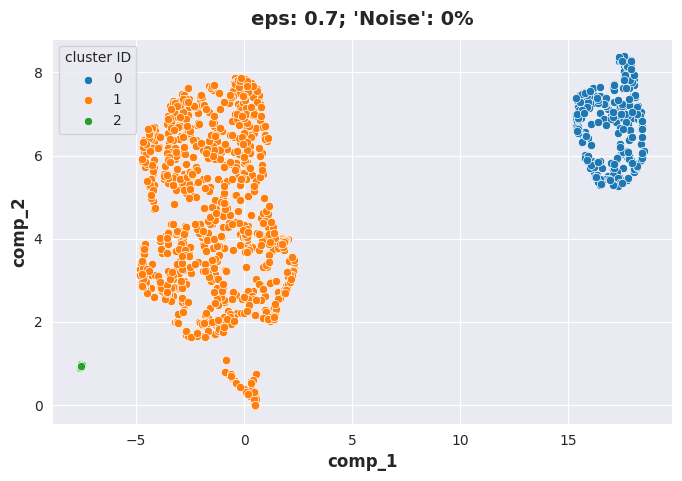

CPU times: user 3.95 s, sys: 551 ms, total: 4.51 s
Wall time: 3.98 s


In [41]:
%%time

for e in [0.3, 0.4, 0.5, 0.6, 0.7]:

    dbscan = DBSCAN(eps=e, n_jobs=n_parallel_jobs)
    labels_5 = dbscan.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_5, hyperparam_name=dbscan_hparam, hyperparam_val=e, noise_exist=True)

Seems 0.5 is the best

### Re-run with optimised *eps*

In [42]:
%%time

eps_val = 0.7

start_time = time.time()

dbscan = DBSCAN(eps=eps_val, n_jobs=n_parallel_jobs)

labels_5 = dbscan.fit_predict(X)

training_times.append(time.time() - start_time)


CPU times: user 16.5 ms, sys: 3.86 ms, total: 20.3 ms
Wall time: 21.8 ms


## Algo 6: OPTICS

OPTICS can be considered an "advanced" version of DBSCAN. Its key difference to the latter is that OPTICS features a **variable neighborhood radius**. Its main hyperparameter to tune is ***min_samples***, which is the number of samples in a neighborhood for a point to be considered as a core point.

In [43]:
# hyperparamter to tune

optics_hparam = "min_samples"

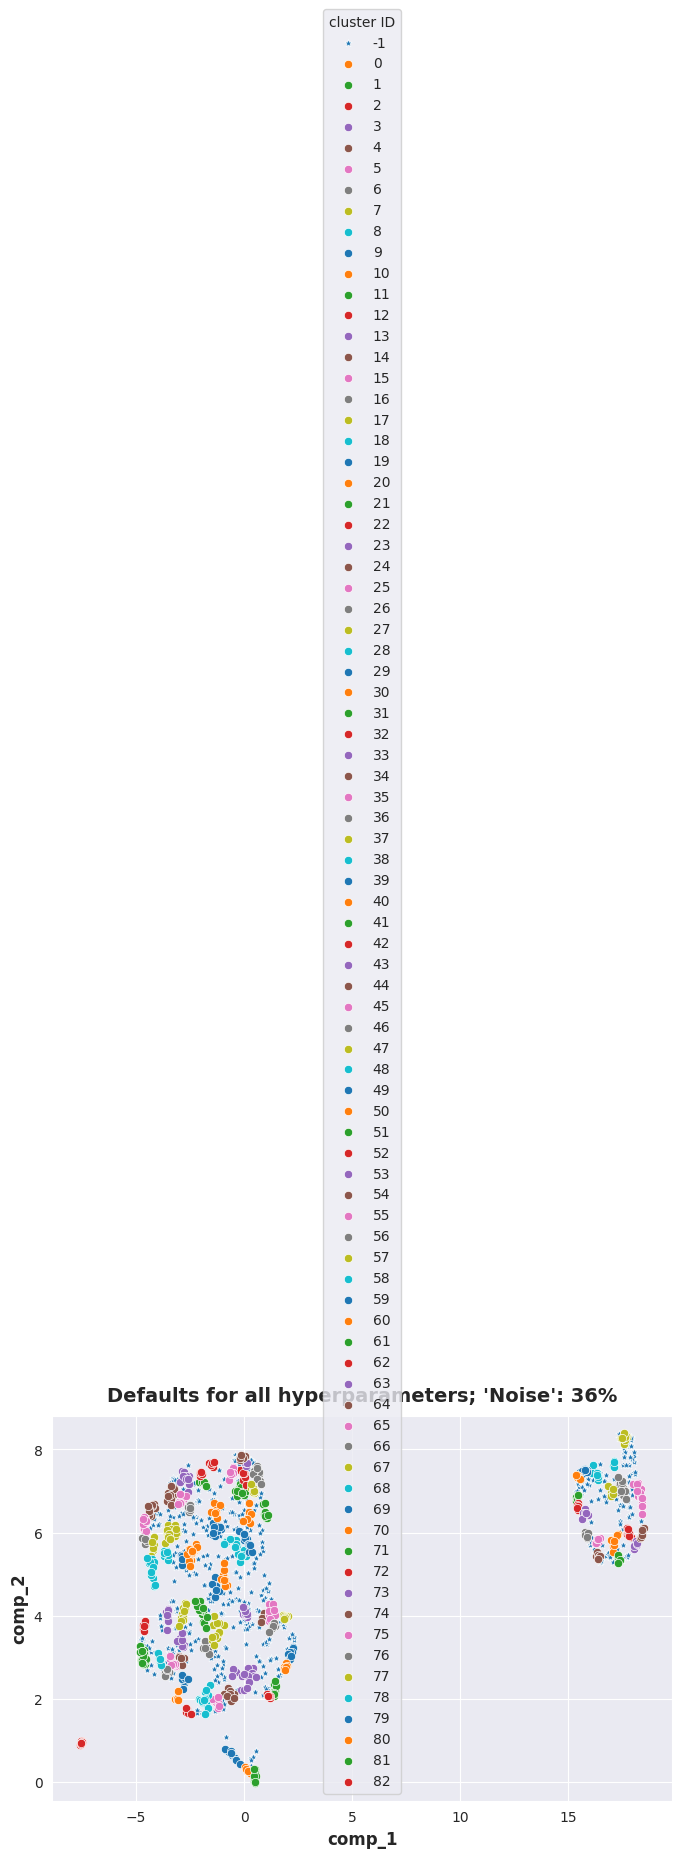

CPU times: user 12.4 s, sys: 1.19 s, total: 13.6 s
Wall time: 34.1 s


In [44]:
%%time

optics = OPTICS(n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=None, hyperparam_val=None, noise_exist=True)

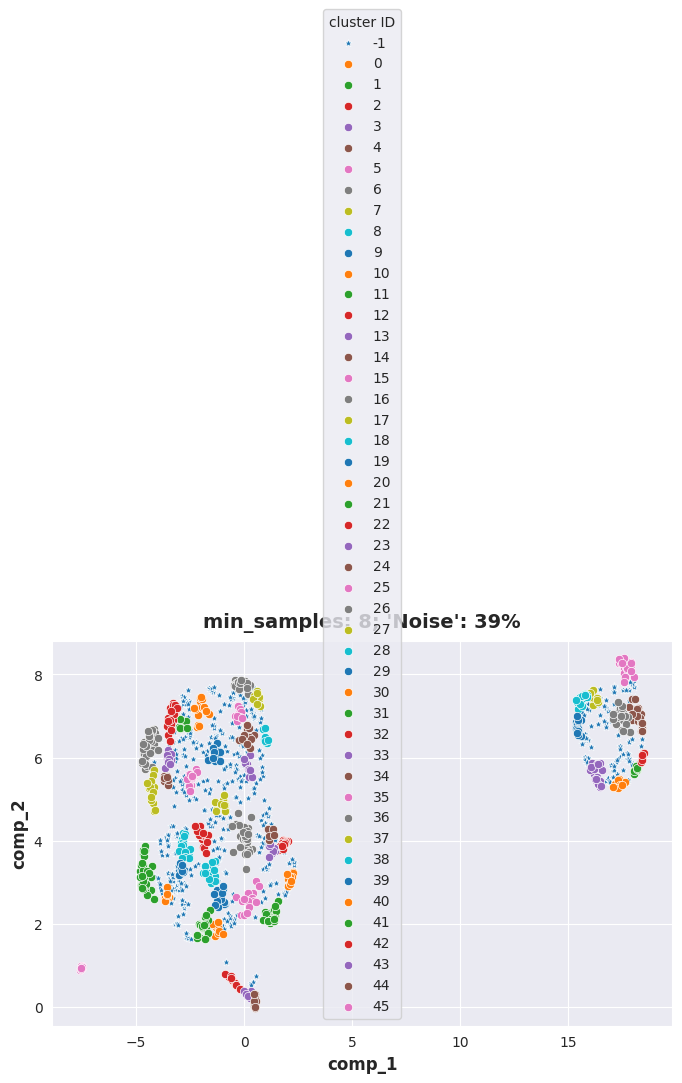

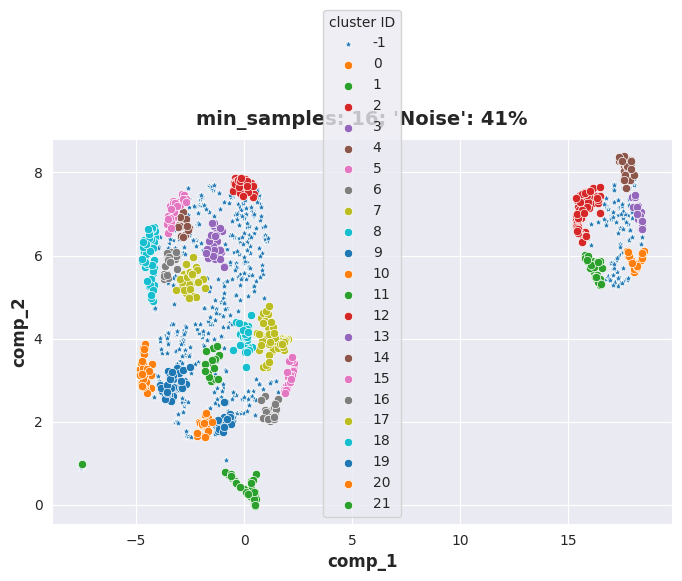

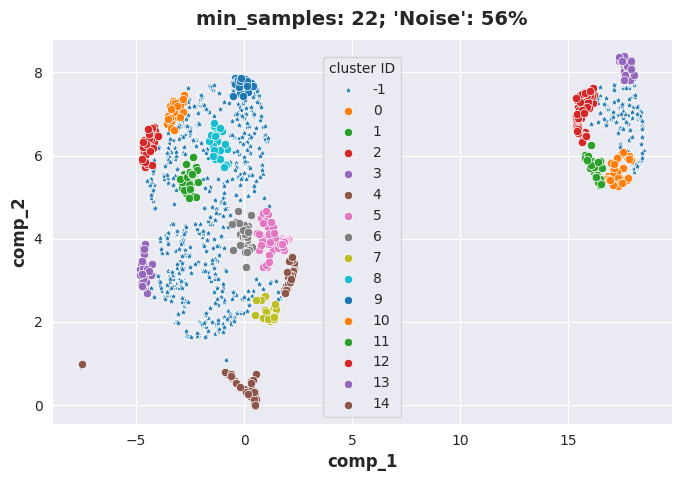

CPU times: user 26.9 s, sys: 5.47 s, total: 32.3 s
Wall time: 1min 28s


In [45]:
%%time

for n_samples in [8, 12, 16, 20, 22]:

    optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

    labels_6 = optics.fit_predict(X)

    visualize_clusters(df=X, labels_all=labels_6, hyperparam_name=optics_hparam, hyperparam_val=n_samples, noise_exist=True)

In [46]:
%%time

n_samples = 20

start_time = time.time()

optics = OPTICS(min_samples=n_samples, n_jobs=n_parallel_jobs)

labels_6 = optics.fit_predict(X)

training_times.append(time.time() - start_time)

CPU times: user 3.53 s, sys: 1.01 s, total: 4.53 s
Wall time: 15.6 s


[0.035959482192993164, 4.244279861450195, 0.06325101852416992, 11.046724319458008, 0.021786928176879883, 15.594375848770142]


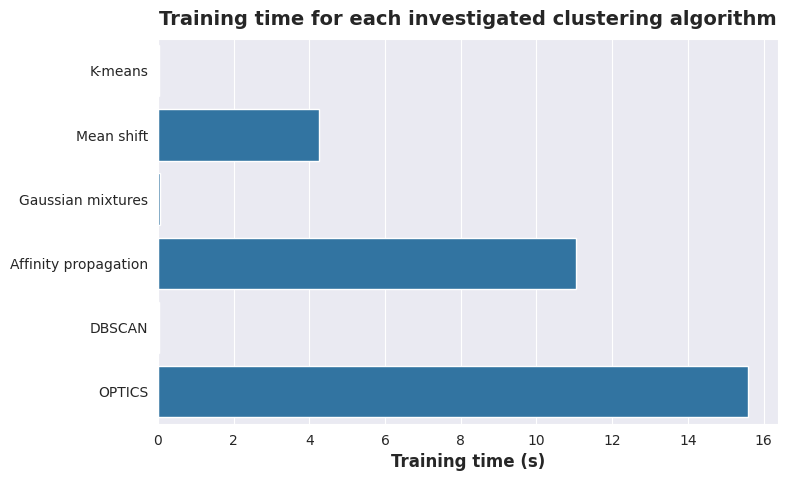

In [47]:
print(training_times)
plt.figure(figsize=std_figure_size)
sns.barplot(y=algos, x=training_times)
plt.title("Training time for each investigated clustering algorithm")
plt.xlabel("Training time (s)")
plt.show()

In [48]:
# overwriting the training time for Mean shift

training_times[1] = training_time_meanshift_noise

In [49]:
# overwriting the training time for Mean shift

plt.figure(figsize=std_figure_size)
sns.barplot(y=algos[:-1], x=training_times[:-1])
plt.title("Training times excluding OPTICS")
plt.xlabel("Training time (s)")
plt.show()

# MLP

In [50]:
df.head()

subject_id  icustay_id  heart_rate  blood_pressure  oxygen_saturation  \
15841       69518    266873.0        97.0           120.0               97.0   
19143       82175    224314.0        91.0            93.0               99.0   
20359       77576    211902.0        90.0            85.0               97.0   
21114       76165    239678.0        66.0            93.0               97.0   
16935       47989    230854.0        94.0            97.0               98.0   

       respiratory_rate  temperature  label  
15841              16.0         36.5      0  
19143              27.0         38.0      1  
20359              26.0         37.3      1  
21114              23.0         36.2      1  
16935              16.0         37.5      0

In [51]:
dataset = df.values
dataset

array([[6.95180e+04, 2.66873e+05, 9.70000e+01, ..., 1.60000e+01,
        3.65000e+01, 0.00000e+00],
       [8.21750e+04, 2.24314e+05, 9.10000e+01, ..., 2.70000e+01,
        3.80000e+01, 1.00000e+00],
       [7.75760e+04, 2.11902e+05, 9.00000e+01, ..., 2.60000e+01,
        3.73000e+01, 1.00000e+00],
       ...,
       [9.18270e+04, 2.08132e+05, 9.80000e+01, ..., 2.70000e+01,
        3.63000e+01, 1.00000e+00],
       [5.74600e+04, 2.88565e+05, 9.50000e+01, ..., 2.40000e+01,
        3.68000e+01, 1.00000e+00],
       [9.84940e+04, 2.82293e+05, 9.70000e+01, ..., 2.90000e+01,
        3.72000e+01, 1.00000e+00]])

In [52]:
X = dataset[:,0:7]
Y = dataset[:,7]

Y

array([0., 1., 1., ..., 1., 1., 1.])

In [53]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_scale = min_max_scaler.fit_transform(X)

X_scale

array([[6.95146623e-01, 6.68905595e-01, 5.50002365e-06, ...,
        1.31868132e-02, 1.31868132e-02, 3.67203219e-01],
       [8.21909302e-01, 2.42885314e-01, 4.90002107e-06, ...,
        1.53846154e-02, 2.52747253e-02, 3.82293763e-01],
       [7.75849291e-01, 1.18639826e-01, 4.80002064e-06, ...,
        1.31868132e-02, 2.41758242e-02, 3.75251509e-01],
       ...,
       [9.18576236e-01, 8.09017107e-02, 5.60002408e-06, ...,
        1.42857143e-02, 2.52747253e-02, 3.65191147e-01],
       [5.74383062e-01, 8.86044905e-01, 5.30002279e-06, ...,
        1.20879121e-02, 2.19780220e-02, 3.70221328e-01],
       [9.85347729e-01, 8.23261494e-01, 5.50002365e-06, ...,
        1.31868132e-02, 2.74725275e-02, 3.74245473e-01]])

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y, test_size=0.3)

In [55]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [56]:
print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

(821, 7) (176, 7) (176, 7) (821,) (176,) (176,)


In [57]:
from keras.models import Sequential
from keras.layers import Dense

In [163]:
#  sequentially (layer by layer)
#  ‘Dense’ refers to a fully-connected layer
model = Sequential([
    Dense(32, activation='relu', input_shape=(7,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# ‘sgd’ refers to stochastic gradient descent
# The loss function for outputs that take the values 1 or 0 is called binary cross entropy.
# we want to track accuracy on top of the loss function
model.compile(optimizer='sgd',
              loss='binary_crossentropy', # loss mse , binary_crossentropy
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=50,
          validation_data=(X_val, Y_val))

# The reason why we have the index 1 after the model.evaluate function is because the function returns the loss as the first element and the accuracy as the second element.
model.evaluate(X_test, Y_test)[1]

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

Epoch 1/50
26/26 [==============================] - 3s 34ms/step - loss: 0.6192 - accuracy: 0.7844 - val_loss: 0.6156 - val_accuracy: 0.7330
Epoch 2/50
26/26 [==============================] - 0s 9ms/step - loss: 0.5863 - accuracy: 0.7844 - val_loss: 0.5957 - val_accuracy: 0.7330
Epoch 3/50
26/26 [==============================] - 0s 11ms/step - loss: 0.5639 - accuracy: 0.7844 - val_loss: 0.5838 - val_accuracy: 0.7330
Epoch 4/50
26/26 [==============================] - 0s 10ms/step - loss: 0.5492 - accuracy: 0.7844 - val_loss: 0.5773 - val_accuracy: 0.7330
Epoch 5/50
26/26 [==============================] - 0s 10ms/step - loss: 0.5395 - accuracy: 0.7844 - val_loss: 0.5736 - val_accuracy: 0.7330
Epoch 6/50
26/26 [==============================] - 0s 10ms/step - loss: 0.5329 - accuracy: 0.7844 - val_loss: 0.5721 - val_accuracy: 0.7330
Epoch 7/50
26/26 [==============================] - 0s 12ms/step - loss: 0.5289 - accuracy: 0.7844 - val_loss: 0.5718 - val_accuracy: 0.7330
Epoch 8/50
26/

Epoch 1/8
26/26 [==============================] - 3s 37ms/step - loss: 0.6649 - accuracy: 0.6943 - val_loss: 0.6422 - val_accuracy: 0.7330
Epoch 2/8
26/26 [==============================] - 0s 9ms/step - loss: 0.6170 - accuracy: 0.7844 - val_loss: 0.6126 - val_accuracy: 0.7330
Epoch 3/8
26/26 [==============================] - 0s 9ms/step - loss: 0.5867 - accuracy: 0.7844 - val_loss: 0.5941 - val_accuracy: 0.7330
Epoch 4/8
26/26 [==============================] - 0s 5ms/step - loss: 0.5659 - accuracy: 0.7844 - val_loss: 0.5828 - val_accuracy: 0.7330
Epoch 5/8
26/26 [==============================] - 0s 6ms/step - loss: 0.5519 - accuracy: 0.7844 - val_loss: 0.5762 - val_accuracy: 0.7330
Epoch 6/8
26/26 [==============================] - 0s 9ms/step - loss: 0.5423 - accuracy: 0.7844 - val_loss: 0.5728 - val_accuracy: 0.7330
Epoch 7/8
26/26 [==============================] - 0s 8ms/step - loss: 0.5361 - accuracy: 0.7844 - val_loss: 0.5711 - val_accuracy: 0.7330
Epoch 8/8
6/6 [===========

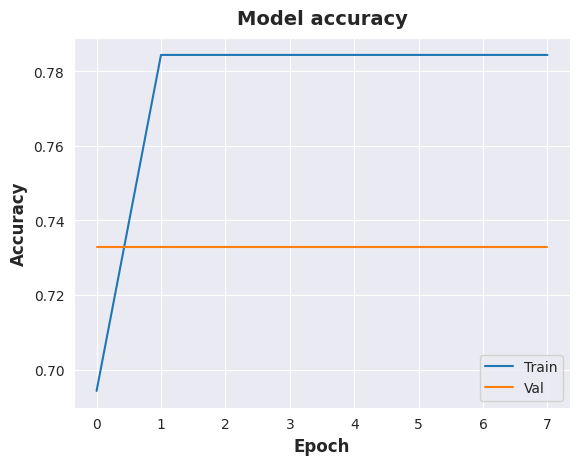

In [164]:
#  sequentially (layer by layer)
#  ‘Dense’ refers to a fully-connected layer
model = Sequential([
    Dense(32, activation='relu', input_shape=(7,)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid'),
])

# ‘sgd’ refers to stochastic gradient descent
# The loss function for outputs that take the values 1 or 0 is called binary cross entropy.
# we want to track accuracy on top of the loss function
model.compile(optimizer='sgd',
              loss='binary_crossentropy', # loss mse , binary_crossentropy
              metrics=['accuracy'])

hist = model.fit(X_train, Y_train,
          batch_size=32, epochs=8,
          validation_data=(X_val, Y_val))

# The reason why we have the index 1 after the model.evaluate function is because the function returns the loss as the first element and the accuracy as the second element.
model.evaluate(X_test, Y_test)[1]

import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [181]:
model_2 = Sequential([
    Dense(128, activation='relu', input_shape=(7,)),
    Dense(128, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid'),
])

In [182]:
model_2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [183]:
hist_2 = model_2.fit(X_train, Y_train,
          batch_size=32, epochs=150,
          validation_data=(X_val, Y_val))

Epoch 1/150
26/26 [==============================] - 1s 10ms/step - loss: 0.5813 - accuracy: 0.7552 - val_loss: 0.5779 - val_accuracy: 0.7330
Epoch 2/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5182 - accuracy: 0.7844 - val_loss: 0.5650 - val_accuracy: 0.7330
Epoch 3/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5163 - accuracy: 0.7844 - val_loss: 0.5667 - val_accuracy: 0.7330
Epoch 4/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5118 - accuracy: 0.7844 - val_loss: 0.5733 - val_accuracy: 0.7330
Epoch 5/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5098 - accuracy: 0.7844 - val_loss: 0.5615 - val_accuracy: 0.7330
Epoch 6/150
26/26 [==============================] - 0s 3ms/step - loss: 0.5089 - accuracy: 0.7844 - val_loss: 0.5784 - val_accuracy: 0.7330
Epoch 7/150
26/26 [==============================] - 0s 4ms/step - loss: 0.5039 - accuracy: 0.7844 - val_loss: 0.5591 - val_accuracy: 0.7330
Epoch 8/150


In [184]:
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

In [185]:
plt.plot(hist_2.history['accuracy'])
plt.plot(hist_2.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

In [186]:
from keras.layers import Dropout
from keras import regularizers

In [192]:
model_3 = Sequential([
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(7,)),
    Dropout(0.3),
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.3),
    Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.01)),
])

In [193]:
model_3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [194]:
hist_3 = model_3.fit(X_train, Y_train,
          batch_size=32, epochs=150,
          validation_data=(X_val, Y_val))

Epoch 1/150
26/26 [==============================] - 1s 11ms/step - loss: 1.7517 - accuracy: 0.7600 - val_loss: 1.4867 - val_accuracy: 0.7330
Epoch 2/150
26/26 [==============================] - 0s 4ms/step - loss: 1.2645 - accuracy: 0.7844 - val_loss: 1.1332 - val_accuracy: 0.7330
Epoch 3/150
26/26 [==============================] - 0s 4ms/step - loss: 0.9768 - accuracy: 0.7844 - val_loss: 0.9155 - val_accuracy: 0.7330
Epoch 4/150
26/26 [==============================] - 0s 4ms/step - loss: 0.8077 - accuracy: 0.7844 - val_loss: 0.7855 - val_accuracy: 0.7330
Epoch 5/150
26/26 [==============================] - 0s 3ms/step - loss: 0.7007 - accuracy: 0.7844 - val_loss: 0.7104 - val_accuracy: 0.7330
Epoch 6/150
26/26 [==============================] - 0s 4ms/step - loss: 0.6372 - accuracy: 0.7844 - val_loss: 0.6680 - val_accuracy: 0.7330
Epoch 7/150
26/26 [==============================] - 0s 4ms/step - loss: 0.6056 - accuracy: 0.7844 - val_loss: 0.6410 - val_accuracy: 0.7330
Epoch 8/150


In [195]:
plt.plot(hist_3.history['loss'])
plt.plot(hist_3.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylim(top=1.2, bottom=0)
plt.show()

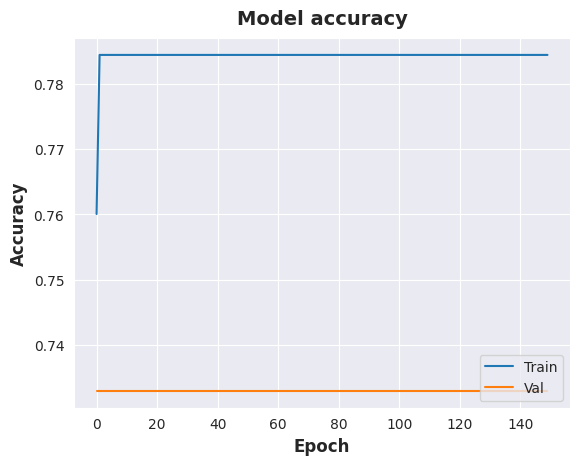

In [196]:
plt.plot(hist_3.history['accuracy'])
plt.plot(hist_3.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='lower right')
plt.show()

# VSC

In [197]:
!pip install -r requirements.txt

In [198]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import datasets

In [283]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
X_train

array([[4.48510e+04, 2.26614e+05, 9.20000e+01, ..., 9.50000e+01,
        1.60000e+01, 3.80000e+01],
       [4.38700e+04, 2.20671e+05, 9.20000e+01, ..., 9.80000e+01,
        3.50000e+01, 3.65000e+01],
       [4.59790e+04, 2.13016e+05, 9.30000e+01, ..., 9.80000e+01,
        3.30000e+01, 3.73000e+01],
       ...,
       [4.39700e+04, 2.88134e+05, 4.20000e+01, ..., 9.70000e+01,
        2.10000e+01, 3.73000e+01],
       [3.06500e+03, 2.70036e+05, 9.80000e+01, ..., 9.50000e+01,
        2.60000e+01, 3.79000e+01],
       [7.06080e+04, 2.89413e+05, 9.50000e+01, ..., 9.50000e+01,
        1.60000e+01, 3.84000e+01]])

In [284]:
model = tf.keras.models.Sequential()

In [285]:
# First our input layer. For this layer, and this layer only, we need to specify the size of our input. For our dataset this means the amount of columns in our X.
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(X.shape[1],)))
# Now some hidden layers
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(10, activation=tf.nn.relu))
# Finally, our output layer. Since we have 3 possible classes, we need 3 output neurons.
# For a regression problem, we would have only 1. For an image creation network, we would have as many pixels as the image we wanted to create!
model.add(tf.keras.layers.Dense(3))
# A final layer with several output neurons gives us logits as results. We can do a final pass with a Softmax layer to turn them into percentages.
model.add(tf.keras.layers.Softmax())

In [286]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)

In [287]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    optimizer=optim,metrics=['accuracy'])
history = model.fit(X_train, y_train, # Removed .values
        validation_data=(X_test, y_test), # Removed .values
        epochs = 5,
        batch_size=32)

Epoch 1/5
30/30 [==============================] - 2s 15ms/step - loss: 5699.0093 - accuracy: 0.6887 - val_loss: 894.2517 - val_accuracy: 0.7489
Epoch 2/5
30/30 [==============================] - 0s 5ms/step - loss: 1172.7650 - accuracy: 0.6748 - val_loss: 223.6765 - val_accuracy: 0.7489
Epoch 3/5
30/30 [==============================] - 0s 5ms/step - loss: 394.0189 - accuracy: 0.6503 - val_loss: 608.5862 - val_accuracy: 0.7489
Epoch 4/5
30/30 [==============================] - 0s 8ms/step - loss: 336.2848 - accuracy: 0.6450 - val_loss: 673.3770 - val_accuracy: 0.7489
Epoch 5/5
30/30 [==============================] - 0s 5ms/step - loss: 431.1484 - accuracy: 0.6663 - val_loss: 604.5770 - val_accuracy: 0.7489


In [288]:
history.history

{'loss': [5699.00927734375,
  1172.7650146484375,
  394.0189208984375,
  336.2847900390625,
  431.14837646484375],
 'accuracy': [0.6886993646621704,
  0.6748400926589966,
  0.6503198146820068,
  0.6449893116950989,
  0.6663113236427307],
 'val_loss': [894.251708984375,
  223.6764678955078,
  608.5862426757812,
  673.3770141601562,
  604.5769653320312],
 'val_accuracy': [0.7489361763000488,
  0.7489361763000488,
  0.7489361763000488,
  0.7489361763000488,
  0.7489361763000488]}

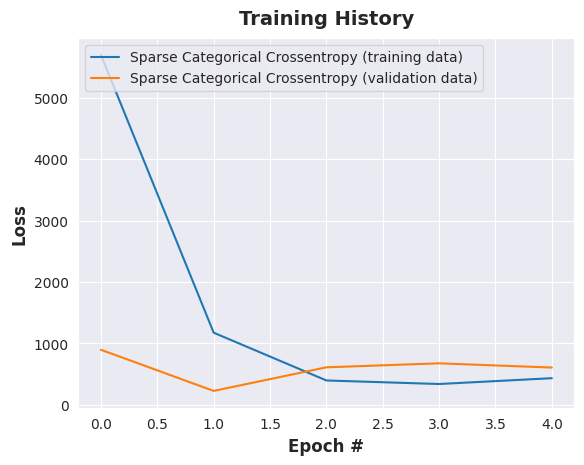

In [289]:
# Plot history
plt.plot(history.history['loss'], label='Sparse Categorical Crossentropy (training data)')
plt.plot(history.history['val_loss'], label='Sparse Categorical Crossentropy (validation data)')
plt.title('Training History')
plt.ylabel('Loss')
plt.xlabel('Epoch #')
plt.legend(loc="upper left")
plt.show()

In [290]:
model.predict(X_test[:1])

1/1 [==============================] - 0s 421ms/step


array([[0., 1., 0.]], dtype=float32)

In [293]:
predictions = model.predict(X_test)
valid = 0
for idx, prediction in enumerate(predictions):
    if np.argmax(prediction) == y_test[idx]:
        valid += 1
    print('We predict: '+str(np.argmax(prediction))+'. Real Species was: '+str(y_test[idx])) # Use array indexing

print('Accuracy: '+str(valid/len(predictions)))

8/8 [==============================] - 0s 4ms/step
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 0.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Species was: 1.0
We predict: 1. Real Spec